# Repetition 
Finding repeating patterns in audio by building Self-Similarity Matrix.\
This notebook uses fmp library (Fundamentals of Music Processing).

In [1]:
# %pip install Ipython
# %pip install libfmp

In [2]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
import librosa.display


sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4
import libfmp.c6
%matplotlib inline

## Import audio and defining parameters

In [13]:
# Read audio file
fn_wav = 'audios/perfect_complete.wav'
x, Fs = librosa.load(fn_wav, sr =22050)

# Audio features 
### window parameters
n_fft, hop_length = 4410, 2205
### chroma sample rate Fs_C
Fs_C = Fs/2205 #10Hz
### song duration
x_duration = x.shape[0]/Fs
print(f"Audio loaded")
print(f"Sample rate of {Fs}Hz, Song's duration of {round(x_duration,2)} s")

Audio loaded
Rate of 22050Hz, Song's duration of 263.49 s


# Chromagram

*FMP notebook: SSM Feature Smoothing	[Section 4.2.2.1]*

For the analysis, it is better to use a chromagram smoothed.

**Chromagram smoothed (X)**

"Using a smoothing length of  L=41  (corresponding to roughly four seconds of audio) and a downsampling by  H=10 (resulting in a feature rate of 1  Hz),\
we obtains an SSM where many of the details have been smoothed out, and some of the structurally relevant path and block structures have become more prominent."

Quando filt_len = 1 e down_sampling = 1, temos os audio comum a 10 Hz.

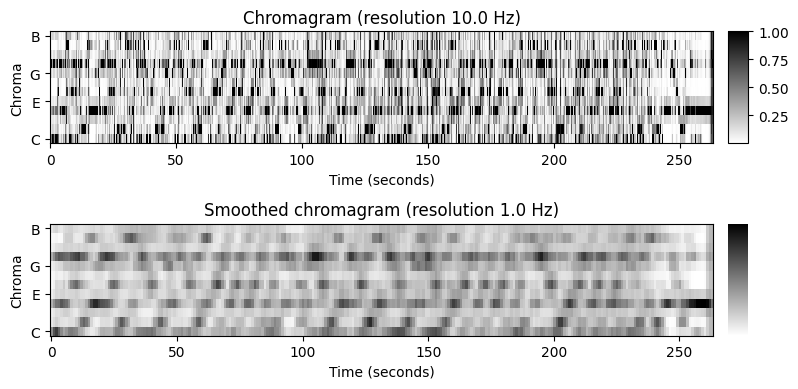

In [17]:
# Commom Chroma (releated parameters: C, Fs_C)
chromagram = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, hop_length=hop_length, n_fft=n_fft)
## chroma without smoothing, use filt=1 and downsample =1

# Smoothed Chromagram (releated parameters: X, Fs_X)
filt_len = 41 # L
down_sampling = 10 # H
X, Fs_X = libfmp.c3.smooth_downsample_feature_sequence(chromagram, Fs_C, filt_len=filt_len,
                                                        down_sampling=down_sampling)

# Visualization
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 2]}, figsize=(8, 4))       
## chroma
libfmp.b.plot_chromagram(chromagram, Fs=Fs/hop_length, ax=[ax[0,0], ax[0,1]],  
                         chroma_yticks = [0,4,7,11], 
                         title='Chromagram (resolution %0.1f Hz)'%(Fs/hop_length), 
                         ylabel='Chroma', colorbar=True)
## chroma smoothed
libfmp.b.plot_chromagram(X, Fs_X, ax=[ax[1,0], ax[1,1]],  
                         chroma_yticks = [0,4,7,11], 
                         title='Smoothed chromagram (resolution %0.1f Hz)'%Fs_X, 
                         ylabel='Chroma', colorbar=True)

ax[1,1].axis('off')
plt.tight_layout()



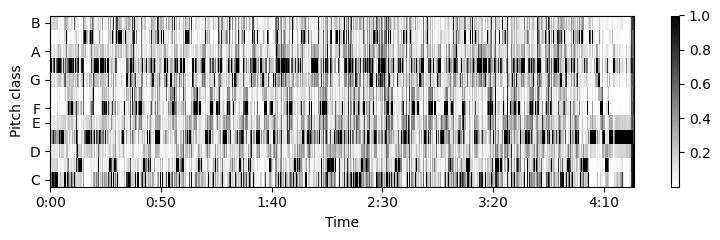

In [13]:
# another way of plotting
plt.figure(figsize=(8, 2.5))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', sr=Fs, 
                         hop_length=hop_length, cmap='gray_r')
plt.colorbar()
plt.tight_layout()
plt.show()

# Self-Similarity Matrix (S)
To build the matrix, it is necessary to:
- normalize the chromagram values (norm = 2 : transform in an unit vector)
- compute a dot distance between chromagram smoothed and chromagram smoothed itself
- apply filters: average, diagonal, Thresholding

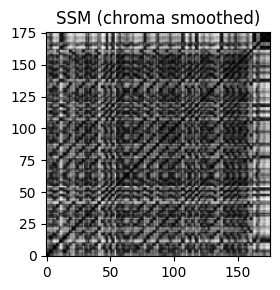

In [23]:
def compute_sm_dot(X, Y):
    """Computes similarty matrix from feature sequences using dot (inner) product

    Notebook: C4/C4S2_SSM.ipynb

    Args:
        X (np.ndarray): First sequence
        Y (np.ndarray): Second Sequence

    Returns:
        S (float): Dot product
    """
    S = np.dot(np.transpose(X), Y)
    return S

# SSM normalized
X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
S = compute_sm_dot(X,X)

# plot
fig = plt.figure(figsize=(10,3))
plt.imshow(S, cmap='gray_r', aspect='equal', origin='lower')
plt.title("SSM (chroma smoothed)")
plt.tight_layout() 
plt.show()


**Applying Filters**

There are other filters besisdes the average, such as median and strong.\
Here a comparison between them.

if **avarege smooth** is the best-> use **smooth_downsample_feature_sequence** to smooth the chroma\
if **median smooth** is the best-> use **median_downsample_feature_sequence** to smooth the chroma

only visualizations so we can choose the better fit! 

SSMs obtained using average filtering


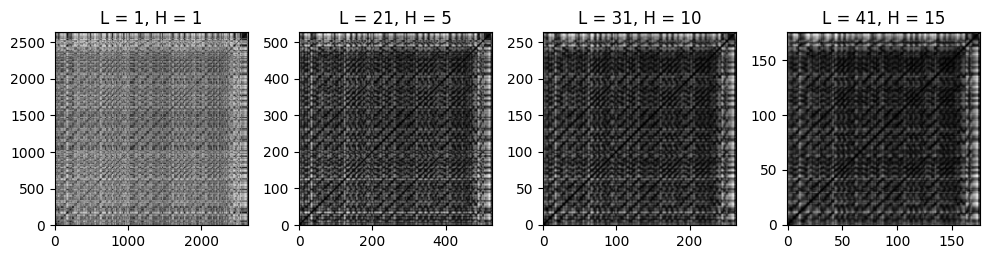

SSMs obtained using median filtering


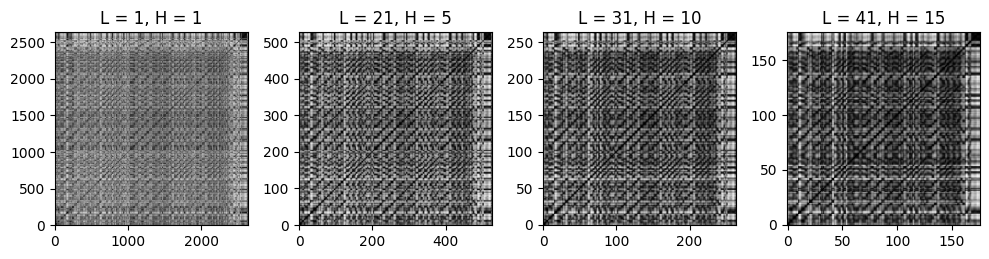

In [20]:
# TESTING FILTERS!! Average x Median 
L_iter = [1, 21, 31, 41] 
H_iter = [ 1, 5, 10, 15]
num_iter = len(L_iter)

print('only visualizations so we can choose the better fit! \n')
print('SSMs obtained using average filtering')
fig = plt.figure(figsize=(10,3))
for i in range(num_iter):
    L = L_iter[i]
    H = H_iter[i]
    X, Fs_feature = libfmp.c3.smooth_downsample_feature_sequence(chromagram, Fs_C, 
                        filt_len=L, down_sampling=H)
    X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
    S = libfmp.c4.compute_sm_dot(X,X)
    ax = fig.add_subplot(1, num_iter, i+1)
    #ax = plt.subplot(1, num_iter, i+1)
    im = plt.imshow(S, cmap='gray_r', aspect='equal', origin='lower')
    ax.title.set_text('L = %d, H = %d'%(L,H))
plt.tight_layout() 
plt.show()

print('SSMs obtained using median filtering')
fig = plt.figure(figsize=(10,3))
for i in range(num_iter):
    L = L_iter[i]
    H = H_iter[i]
    X, Fs_feature = libfmp.c3.median_downsample_feature_sequence(chromagram, Fs_C, 
                        filt_len=L, down_sampling=H)
    X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)
    S = libfmp.c4.compute_sm_dot(X,X)
    ax = fig.add_subplot(1, num_iter, i+1)
    im = plt.imshow(S, cmap='gray_r', aspect='equal', origin='lower')
    ax.title.set_text('L = %d, H = %d'%(L,H))
plt.tight_layout() 
plt.show()



**Diagonal (S_L)**

"One important property of similarity matrices is the appearance of paths of high similarity that are **parallel to the main diagonal**.\
Each such path encodes the similarity of two segments that are obtained by projecting the path onto the horizontal and vertical axes, respectively. "

"A simple filtering along the main diagonal works well if there are no **relative tempo differences** between the segments to be compared.\
However, this assumption is violated when a part is repeated with a faster or slower tempo. To deal with non-diagonal path structures due relative tempo differences,\
we introduce a multiple filtering approach"

"Some times there is a fading artifact in particular at the end of path structures. The reason for this artifact is that the smoothing procedure described so far\
works in the forward direction. To avoid fading artifacts, one idea is to additionally apply the averaging filter in a backward direction.\
The final self-similarity matrix is then obtained by taking the cell-wise maximum over the **forward-smoothed and backward-smoothed** matrices."

- L is the length of filter (default = 4)

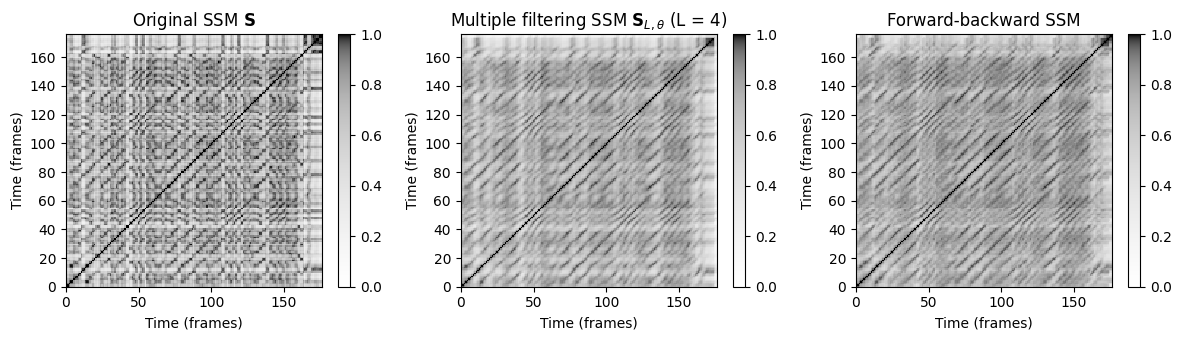

In [24]:
L = 4

# Relative tempo differences
### Song with constante tempo -> all = 1
### Songs with diferents tempos -> edit
tempo_rel_min = 1
tempo_rel_max = 1
num = 1 # how many differents times the song has ( number contains mim and max )
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(tempo_rel_min=tempo_rel_min, tempo_rel_max=tempo_rel_max, num=num) 
S_L_mult = libfmp.c4.filter_diag_mult_sm(S, L, tempo_rel_set) 

# Apply diagonal filter 
S_forward = libfmp.c4.filter_diag_mult_sm(S, L, direction=0)
S_backward = libfmp.c4.filter_diag_mult_sm(S, L, direction=1)
S_final = np.maximum(S_forward, S_backward)

# visualize filters
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
libfmp.c4.subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], xlabel='Time (frames)', ylabel='Time (frames)',
                        title=r'Original SSM $\mathbf{S}$')
libfmp.c4.subplot_matrix_colorbar(S_L_mult, fig, ax[1], clim=[0,1], xlabel='Time (frames)', ylabel='Time (frames)',
                        title=r'Multiple filtering SSM $\mathbf{S}_{L,\theta}$ (L = %d)'%L)
libfmp.c4.subplot_matrix_colorbar(S_final, fig, ax[2], clim=[0,1], xlabel='Time (frames)', ylabel='Time (frames)',
                        title=r'Forward-backward SSM')

plt.tight_layout()
plt.show()

**Thresholding**

It leads to a substantial reduction of unwanted noise-like components while leaving only the most significant structures.\
On the other hand, weaker but still relevant information may be lost.

Default: Absolute = 0.35 and Local = 0.15 

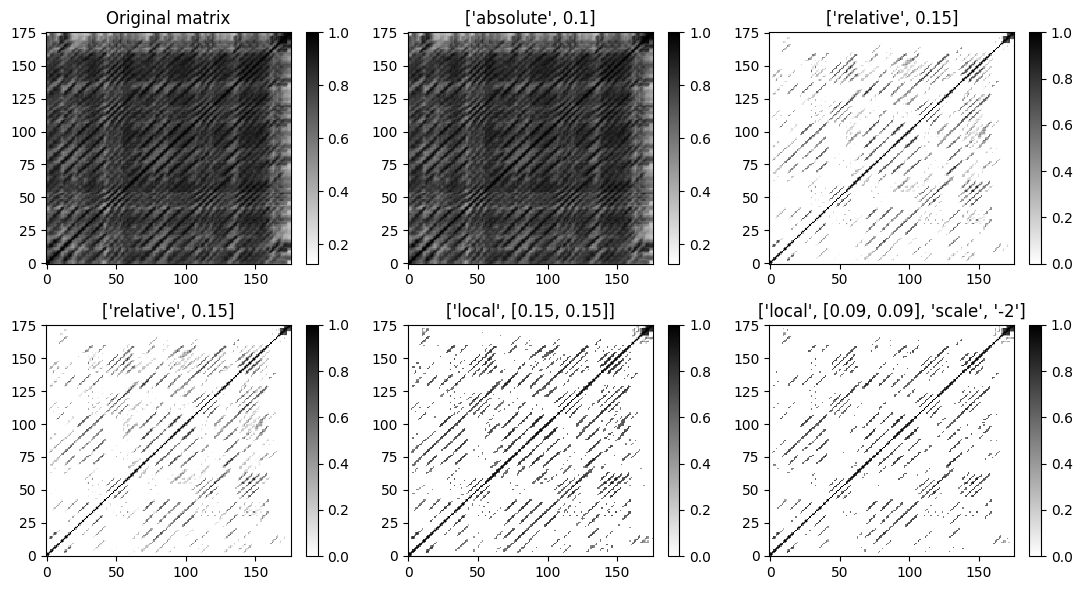

In [25]:
# TESTING VALUES OF THRESHOLDING
S = S_final
figsize=(11, 6)
fig, ax = plt.subplots(2, 3, figsize=figsize)
libfmp.b.plot_matrix(S, ax=[ax[0,0]], xlabel='', ylabel='', title=r'Original matrix')

strategy = 'absolute'
thresh = 0.1
S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy, scale=0, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[0,1]], xlabel='', ylabel='', 
                     title=[strategy, thresh])

strategy = 'relative'
thresh = 0.15
S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[0,2]], xlabel='', ylabel='', 
                     title=[strategy, thresh])

strategy = 'relative'
thresh = 0.15
S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy, scale=2, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[1,0]], xlabel='', ylabel='', 
                     title=[strategy, thresh] )

strategy = 'local'
thresh = [0.15, 0.15]
S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[1,1]], xlabel='', ylabel='', 
                     title=[strategy, thresh])

strategy = 'local'
thresh = [0.09, 0.09]
S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy, scale=2, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[1,2]], xlabel='', ylabel='', 
                     title=[strategy, thresh, "scale", "-2"])

plt.tight_layout()
plt.show()


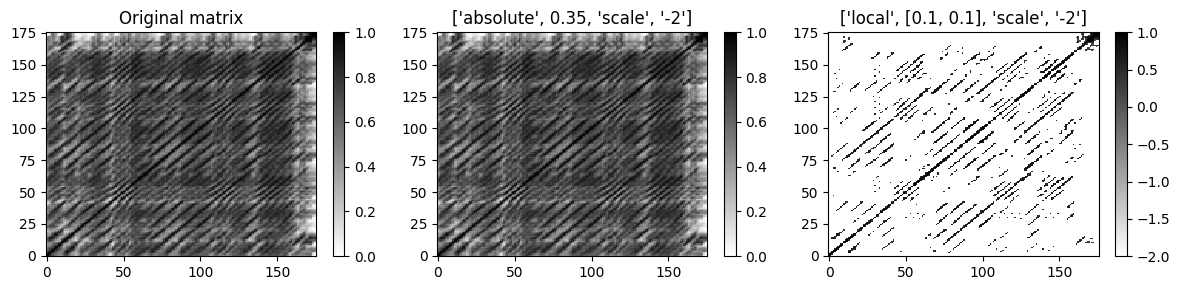

In [34]:
# Sequence of thresholds choosed

S = S_final

# 1. thresh absolute
strategy1 = 'absolute'
thresh1 = 0.35
S_thresh_abs = libfmp.c4.threshold_matrix(S, thresh=thresh1, strategy=strategy1, scale=-2, penalty=0, binarize=0)

# 2.  thresh local
S = S_thresh_abs
strategy2 = 'local'
thresh2 = [0.10, 0.10]
S_thresh_abs_rel = libfmp.c4.threshold_matrix(S, thresh=thresh2, strategy=strategy2, scale=-2, penalty=-2, binarize=0)

#visualize
figsize=(12,3)
fig, ax = plt.subplots(1,3, figsize=figsize)
libfmp.b.plot_matrix(S, ax=[ax[0]], xlabel='', ylabel='', title=r'Original matrix')
libfmp.b.plot_matrix(S_thresh_abs, ax=[ax[1]], xlabel='', ylabel='', 
                     title=[strategy1, thresh1, "scale", "-2"])
libfmp.b.plot_matrix(S_thresh_abs_rel, ax=[ax[2]], xlabel='', ylabel='', 
                     title=[strategy2, thresh2, "scale", "-2"])
plt.tight_layout()
#plt.savefig('SSM_final (40,10)')
plt.show()


# Audio Thumbnailing

- A given segment  α, a path P, an induced segment  π1(P),
- Family = conjunto de paths. Each path has a score. 
- Optimal path family: Family with max score   P∗ = argmax σ(P). 
- COMO ACHAR A FAMILIA IDEIAL 1 : Dada uma secção da matrix (S_seg), calcula o accumulated score matrix  D  using dynamic programming, e apartir dele pode encontrar as familias otimas.

- A large score  σ(P)  indicates that the path components of  P  express strong similarity relations among its segments.
- Besides repetitiveness, another issue is how much of the underlying music recording is covered by the thumbnail and its related segments. 
- Both features needs to bem normalized, so it doesnt matter the lengths of the paths:  normalized score  σ¯(α) and coverage  γ¯(α) 
- To balance out these two trends, we combine the score and coverage measure by taking a suitable average. In particular, we define the fitness  φ(α)  of the segment  α  to be the harmonic mean.


In [41]:
SSM = S_thresh_abs_rel 

# finding family for a given segment
seg_seconds = [64.505, 102.261] # example
seg = [int(seg_seconds[0]*Fs_X), int(seg_seconds[1]*Fs_X)]
S_seg = S[:,seg[0]:seg[1]+1] # sub Matrix corresponde a esse seg (alfa)

D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
path_family = libfmp.c4.compute_optimal_path_family(D)

N = SSM.shape[0] #  N (int): Length of feature sequence

segment_family, coverage = libfmp.c4.compute_induced_segment_family_coverage(path_family)
fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(
    path_family, score, N)

print("family: \n", segment_family)
print( "fitness score: \n", fitness)

# visualize family 
#fig, ax, im = libfmp.c4.plot_ssm_ann_optimal_path_family(S, seg, ylabel='Time (frames)')
#plt.show()


family: 
 [[  0  36]
 [ 37  63]
 [ 64 102]
 [103 125]
 [126 149]
 [150 175]]
fitness score: 
 0.6819913586486969


In [42]:
# check values
path_family = libfmp.c4.check_segment(seg, S)

Segment (alpha): [64, 102]
Length of segment: 39
Length of feature sequence: 176
Induced segment path family:
 [[  0  36]
 [ 37  63]
 [ 64 102]
 [103 125]
 [126 149]
 [150 175]]
Fitness: 0.6819913586
Score: 145.8014990628
Normalized score: 0.6068266992
Coverage: 176, 176
Normalized coverage: 0.7784090909
Length of all paths of family: 176


In [ ]:
# Fuction that gives the MATRIX READY!!
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(1,1,1)
penalty = -2

x, x_duration, X, Fs_X, S, I = libfmp.c4.compute_sm_from_filename(fn_wav, L=40, H=10, 
                        L_smooth=4, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh= 0.10)
S = libfmp.c4.normalization_properties_ssm(S)